In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg as la
from tqdm.notebook import tqdm
from typing import List, Tuple
import sys
sys.path.append('/Users/billystrickland/Documents/code/resonators')
from shabanipy.labber import LabberData
import numpy as np
from shabanipy.jy_mpl_settings.settings import jy_mpl_rc
from shabanipy.jy_mpl_settings.colors import line_colors
import utils.resonator_functions as rf
import matplotlib as mpl
import utils.fluxonium_functions as ff

In [13]:
def generate_H_Sm(phi_ax: np.ndarray, 
               VJ_Sm, 
               K: float,
               T: float,
               EC: float, 
               EL: float, 
               ng: float, 
               phi_ext: float) -> Tuple[np.ndarray, np.ndarray]:
    
    phi_N = len(phi_ax)
    dphi = phi_ax[1] - phi_ax[0]
    
    # Calculate first and second derivatives of phase variable
    dphi_dx = (np.diag(np.ones(phi_N - 1), 1) 
               - np.diag(np.ones(phi_N - 1), -1)) / (2 * dphi)
    
    d2phi_dx2 = (-2 * np.diag(np.ones(phi_N), 0) + 
                 np.diag(np.ones(phi_N - 1), 1) + 
                 np.diag(np.ones(phi_N - 1), -1)) / dphi**2
    
    # Calculate the potential energy term 'V'
    V = EL/2 * (phi_ax)**2 + VJ_Sm(phi_ax - phi_ext, K, T)
    
    # Construct the Hamiltonian 'H' for the system
    H = -4 * EC * (d2phi_dx2 - 2 * ng * dphi_dx + ng**2 * np.ones(phi_N)) + np.diag(V)
    
    return H, phi_ax

def VJ_Fr(phi, EJ1, EJ2):
    return - EJ1 * np.cos(phi) - EJ2 * np.cos(2 * phi)

def VJ_Sm(phi, K, T):
    return -K * np.sqrt(1 - T * np.sin(phi / 2) ** 2)

def get_nonsine_freqs_Sm(K=12, T=.95, flux=[-.5, .5], step=61):
    EL = 2.8
    EC = .8
    ng = 0
    
    phi_N = 1001  # Minimum ~ 1000
    phi_max = 10 * np.pi  # Min 10, further increase if the wavefunction tails are too close to the boundary
    phi_ax = np.linspace(-phi_max, phi_max, phi_N)
    
    # Spectrum as function of external flux (reduced coordinate phi_ext = 2 pi Phi / Phi_0)
    M = step
    phi_ext_ax = np.linspace(flux[0] * 2 * np.pi, flux[-1] * 2 * np.pi, M)

    ws = np.zeros((M, phi_N))
    vs = np.zeros((M, phi_N, phi_N))

    for i, phi_ext in tqdm(enumerate(phi_ext_ax), total=len(phi_ext_ax)):

        EJ = np.cos(phi_ax - phi_ext)
        H, phi_ax = generate_H_Sm(phi_ax, VJ_Sm,
                               K = K,
                               T = T,
                               EC = EC, 
                               EL = EL, 
                               ng = ng, 
                               phi_ext = phi_ext)
        ws[i], vs[i] = la.eigh(H)
        
    omegat = []
    label = []
    for i in range(4):
        omegat.append(ws[:, i + 1] - ws[:, 0])    
        label.append(f'$f_{{0{i+1}}}$')
    omegat = np.array(omegat)
    return omegat, phi_ext_ax

colors = ['k', 'k', 'k', 'k', 'k', 'k', 'k']
linestyle_tuple = [
                   (0, (2, 6)),
                   (0, (3, 3, 1, 3, 1, 3)),
                   (0, (3, 1, 1, 6)),
    
                   (0, (1, 3)),
                   (0, (5, 7)),
                   (0, (4, 6)),
                  ]

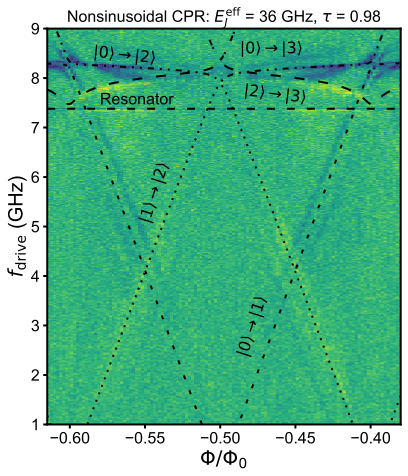

In [29]:
sample='JS801-4fluxonium@v5-01-CD02-WMSLJB'
channels = ['SC3 - Drive - Frequency', 'Qcage - Magnet - Source voltage', 'VNA - S21']

file_num = '948'
day = '04'
month = '04'
year= '2024'

K = 36.5
T = .98

flux_extent = [-.615, -.38] # for file#948

freq, signal, magnet, drive = ff.get_data(file_num, month, day, sample = sample, year = year, channels = channels)

signal = ff.dynamic_slice(signal, dispersive = 0)
signal = rf.average_data(signal.T)
signal = signal.T
signal = -ff.normalize(signal)

# omegat, phi_ext_ax = get_nonsine_freqs_Sm(flux = flux_extent,
#                                           K = K, T = T,
#                                           step = 121)

fig, ax = ff.plot_data(signal, 
      xlim=flux_extent,ylim = drive * 1e-9,
      figsize=(6, 7),
      cbar=False,
      zlim = [0,0]
     )

for i,x in enumerate(omegat[0:3]):
    ax.plot(phi_ext_ax / (2 * np.pi), x, linestyle = linestyle_tuple[i], color = colors[i])

plt.plot(phi_ext_ax / (2 * np.pi), omegat[1] - omegat[0], color = 'black', linestyle =linestyle_tuple[3])
plt.plot(phi_ext_ax / (2 * np.pi), omegat[2] - omegat[0], color = 'black', linestyle =linestyle_tuple[4])

plt.ylim(1, 9)

plt.axhline(y = 7.38, linestyle =linestyle_tuple[-1], color ='k')

ax.annotate(r"$|0\rangle \rightarrow |1\rangle$", xy = (-.49, 2.4), color = colors[0], rotation = 72)
ax.annotate(r"$|0\rangle \rightarrow |2\rangle$", xy=(-.585, 8.3), color = colors[4], rotation=-6 )
ax.annotate(r"$|0\rangle \rightarrow |3\rangle$", xy=(-.487, 8.5), color = colors[2] )
ax.annotate(r"$|1\rangle \rightarrow |2\rangle$", xy=(-.555, 5.1), color = colors[3], rotation=72)
ax.annotate(r"$|2\rangle \rightarrow |3\rangle$", xy = (-.485, 7.5), color = colors[1],  rotation=-7)
ax.annotate(r"Resonator", xy = (-.58,7.47), color = colors[-1] )

plt.title(f'Nonsinusoidal CPR: $E_J^\mathrm{{eff}}$ = {int(K)} GHz, '+r'$\tau$'+f' = 0.98', fontsize = 16)

ff.save_fig(fig, f'nonsinefit', format='pdf')


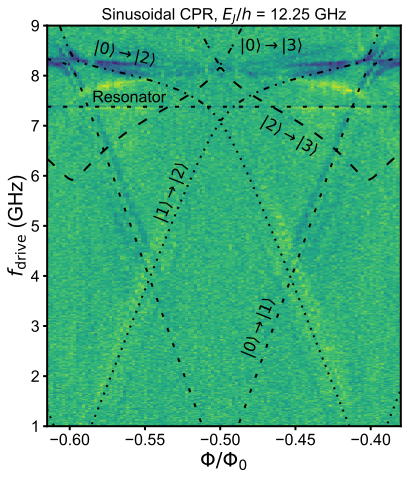

In [49]:
import scqubits as scq
import inspect



sample='JS801-4fluxonium@v5-01-CD02-WMSLJB'
file_num = '948'
day = '04'
month = '04'
year= '2024'
channels = ['SC3 - Drive - Frequency', 'Qcage - Magnet - Source voltage', 'VNA - S21']

_,signal, magnet, drive = ff.get_data(file_num,month,day,sample = sample,year = year,channels = channels)


# magnet = magnet[~np.isnan(magnet)]
signal = ff.dynamic_slice(signal, dispersive = 0)
signal = rf.average_data(signal.T)
signal = signal.T
signal = -ff.normalize(signal)

fig, ax = ff.plot_data(signal, 
          xlim=flux_extent,
          ylim = drive*1e-9,
          figsize=(6, 7),
          zlim = [0, 0 ],
          cbar=False
         )

magnet = np.linspace(flux_extent[0], flux_extent[1], len(signal[0]))

# np.savetxt(f'csvs/twotone_Ej={Ej}.csv', (signal), delimiter=',')
# np.savetxt(f'csvs/drive_Ej={Ej}.csv', (drive), delimiter=',')
# np.savetxt(f'csvs/magnet_Ej={Ej}.csv', (magnet), delimiter=',')


El = 2.8
Ej = 12.25
Ec = .8
dashes=(2,6)

flux_list = np.linspace(flux_extent[0],flux_extent[-1], 151)
fl= scq.Fluxonium(
    EJ=Ej,
    EC=Ec,
    EL=El,
    cutoff = 110,
    flux = 0)
eval_num = 20
spectrum = fl.get_spectrum_vs_paramvals('flux', flux_list, evals_count=eval_num, subtract_ground=True);
E_phi = inspect.getmembers(spectrum)[5][1]["energy_table"].T

f01 = E_phi[1]-E_phi[0]
f02 = E_phi[2]-E_phi[0]
f03 = E_phi[3]-E_phi[0]
f12 = E_phi[2]-E_phi[1]
f23 = E_phi[3]-E_phi[1]
plt.axhline(y=7.38, linestyle = '--', dashes = (2, 6), color = 'k', label='$f_r$')
plt.plot(flux_list, f01, color='k', label='$f_{01}$', linestyle=linestyle_tuple[0])
plt.plot(flux_list, f02, color='k', label='$f_{02}$', linestyle=linestyle_tuple[1])    
plt.plot(flux_list, f03, color='k', label='$f_{03}$', linestyle=linestyle_tuple[2])
plt.plot(flux_list, f12, color='k', label='$f_{12}$', linestyle=linestyle_tuple[3])
plt.plot(flux_list, f23, color='k', label='$f_{12}$', linestyle=linestyle_tuple[4])
plt.xlabel('$\Phi/\Phi_0$')
plt.title(f'Sinusoidal CPR, $E_J/h$ = {Ej} GHz', fontsize = 16)
plt.ylim(1, 9)
ax.annotate(r"$|0\rangle \rightarrow |1\rangle$", xy = (-.487, 2.4), color = colors[0], rotation = 68)
ax.annotate(r"$|0\rangle \rightarrow |2\rangle$", xy=(-.585, 8.2), color = colors[4], rotation=-13 )
ax.annotate(r"$|0\rangle \rightarrow |3\rangle$", xy=(-.487, 8.5), color = colors[2] )
ax.annotate(r"$|1\rangle \rightarrow |2\rangle$", xy=(-.545, 5.1), color = colors[3], rotation=68)
ax.annotate(r"$|2\rangle \rightarrow |3\rangle$", xy = (-.475, 6.4), color = colors[1],  rotation=-30)
ax.annotate(r"Resonator", xy = (-.585,7.47), color = colors[-1] )


ff.save_fig(fig, f'sinefit', format = 'pdf')
